In [1]:
# addprocs(3) # spawn extra workers

In [2]:
using AutomotiveDrivingModels

In [3]:
require(Pkg.dir("AutomotiveDrivingModels", "viz", "Renderer.jl")); @everywhere using .Renderer
require(Pkg.dir("AutomotiveDrivingModels", "viz", "ColorScheme.jl")); @everywhere using .ColorScheme

In [4]:
require(Pkg.dir("AutomotiveDrivingModels", "viz", "incl_cairo_utils.jl"))

# Load Scenario

In [5]:
reload(Pkg.dir("AutomotiveDrivingModels", "scripts", "risk_estimation_policy_opt", "scenario_follow_faster_with_other.jl"))
println("Loaded scenario: ", scenario.name)

Loaded scenario: follow_faster_with_other


In [6]:
sn = scenario.sn
scenario_pdset = create_scenario_pdset(scenario)
horizon = get_horizon(scenario)
history = scenario.history
basics = FeatureExtractBasicsPdSet(scenario_pdset, sn)
active_carid = CARID_EGO
nothing

In [7]:
"hidden reel scenario pdset"
# roll(reel_pdset(scenario_pdset, sn, active_carid), fps=40)

"hidden reel scenario pdset"

# Select Policy Parameters

In [8]:
human_behavior = VehicleBehaviorGaussian(0.00001, 0.1)
policy = RiskEstimationPolicy(human_behavior)
policy.speed_deltas = get_speed_deltas(2, 5.0)
policy.k_c = 100000.0
policy.k_v = 100.0
nothing

In [9]:
"hidden reel default selected policy"
# roll(reel_scenario_playthrough(scenario, policy, pdset=scenario_pdset), fps=2)

"hidden reel default selected policy"

# Select Evaluation Parameters

In [10]:
nruns = 10

10

# Visualize some generated trajectories

Slider{Int64}([Input{Int64}] 201,"validfind",201,1:401)

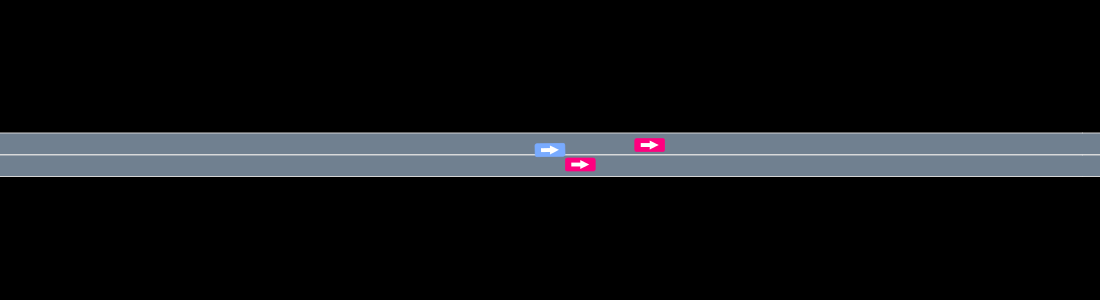

In [31]:
validfind = 205
candidate_trajectories = generate_candidate_trajectories(basics, policy, active_carid, validfind)
extracted_trajdefs, extracted_polies = extract_trajdefs(basics, candidate_trajectories, active_carid, validfind)

traj_index = 15

insert!(pdset, extracted_trajdefs[traj_index])
plot_manipulable_pdset(pdset, sn, active_carid)

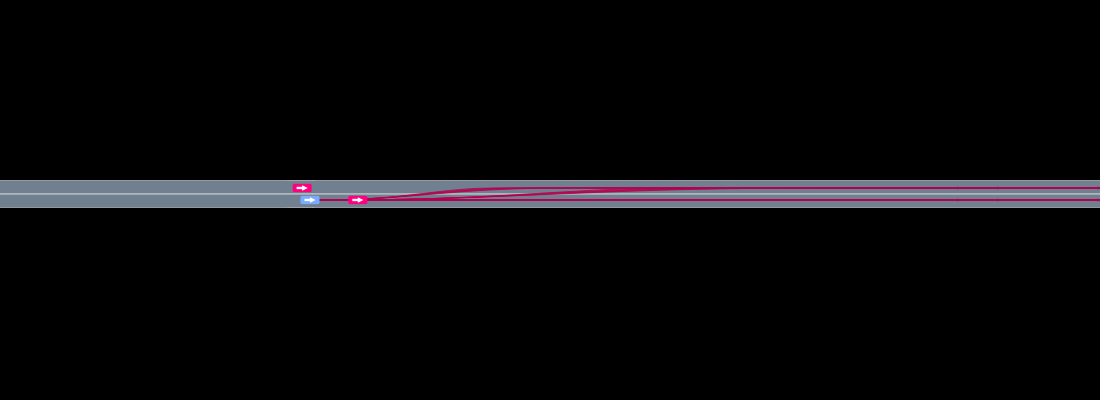

In [91]:
reload(Pkg.dir("AutomotiveDrivingModels", "viz", "incl_cairo_utils.jl"))
plot_extracted_trajdefs(pdset, sn, extracted_trajdefs, validfind, active_carid,
                        canvas_width=canvas_width, canvas_height=canvas_height*2,
                        rendermodel=rendermodel, camerazoom=camerazoom/2,
                        camera_forward_offset=camera_forward_offset)

In [76]:
let 
    validfind = 125
    trajdef = TrajDef(basics.pdset, basics.sn, active_carid, validfind)
    append!(trajdef.links, candidate_trajectories[2])
        
    pdset = basics.pdset
    sn = basics.sn
    carid = CARID_EGO
    frameind_start = 200

    nframes = get_num_pdset_frames(trajdef)
    df = Trajdata._create_df_ego(nframes) # TODO(tim): preallocate this stuff
    extracted = ExtractedTrajdef(df, carid)
    for i = 1 : nrow(df)
        df[i,:frame] = frameind_start + i - 1
        df[i,:time] = sec_per_frame*i
    end

    lane = get_lane(sn, trajdef.lanetag)
    footpoint = curve_at(lane.curve, trajdef.extind)
    footvec = VecSE2(footpoint.x, footpoint.y, footpoint.θ)
    inertial = footvec + Vec.polar(trajdef.d, π/2 + footvec.θ, footvec.θ + trajdef.ϕ)

    println(inertial)
    println(pdset.df_ego[validfind, :posFx])
    println(footpoint)
    
    frameind = 1
    AutomotiveDrivingModels._set_vehicle!(extracted, sn, frameind, inertial, trajdef.v, 
                  footpoint, trajdef.extind, trajdef.lanetag, trajdef.d, trajdef.ϕ)

#     #######################################
#     # Now we select the next link, project our current location to the new lane tag
#     # and move forward!

    a = trajdef.a
    v = trajdef.v
    ψ = trajdef.ψ + footvec.θ # in global coordinates
    
    link_index = 1
    link = trajdef.links[link_index]
    lanetag = link.lanetag    

    extind, lane = project_point_to_lanetag(sn, inertial.x, inertial.y, lanetag)
    curve = lane.curve

    footpoint = curve_at(curve, extind)
    ψ -= footpoint.θ

    s, d₁, ϕ = pt_to_frenet_xyy(footpoint, inertial.x, inertial.y, inertial.θ)
    ddot₁ = v * sin(ϕ) # initial lateral velocity
    dddot₁ = a * sin(ψ) # initial lateral accel

    sdot₁ = v * cos(ϕ) # initial longitudinal velocity
    sddot₁ = a * cos(ψ) # initial longitudinal accel

    (poly, d₂, ddot₂, dddot₂, sdot₂, sddot₂) = AutomotiveDrivingModels.get_polynomial_factored_trajectory(link, sdot₁, sddot₁, d₁, ddot₁, dddot₁, sec_per_frame)
    (inertial, footpoint, extind, frameind, lanetag) = AutomotiveDrivingModels._add_trajlink_to_extracted!(
                                                        pdset, extracted, sn, carid, poly, link.n_pdset_frames,
                                                        sec_per_frame, lane, extind, inertial, footpoint, frameind)

    for i = 1 : 5
        println(extracted.df[i, :velFy])
    end
    
#     n_links = length(trajdef.links)
#     trajs = Array(PolynomialFactoredTrajectory, n_links) # TODO(tim): preallocate
#     trajs[1] = poly
#     link_durations = Array(Float64, n_links) # TODO(tim): preallocate
#     link_durations[1] = link.n_pdset_frames*sec_per_frame

#         link_index += 1
#         link = trajdef.links[link_index]
    
#             v = sqrt(ddot₂*ddot₂ + sdot₂*sdot₂)
#             a = sqrt(dddot₂*dddot₂ + sddot₂*sddot₂)
#             ψ = atan2(dddot₂, sddot₂)

#             lanetag = link.lanetag

#             extind, lane = project_point_to_lanetag(sn, inertial.x, inertial.y, lanetag)
#     curve = lane.curve # THIS IS WHAT I NEEDED
    

#             @assert(!is_extind_at_curve_end(curve, extind))
#             footpoint = curve_at(curve, extind)
#             ψ -= footpoint.θ
    
#             s, d₁, ϕ = pt_to_frenet_xyy(footpoint, inertial.x, inertial.y, inertial.θ)
#             ddot₁ = v * sin(ϕ) # initial lateral velocity
#             dddot₁ = a * sin(ψ) # initial lateral accel

#             sdot₁ = v * cos(ϕ) # initial longitudinal velocity
#             sddot₁ = a * cos(ψ) # initial longitudinal accel
#         end

#         (poly, d₂, ddot₂, dddot₂, sdot₂, sddot₂) = get_polynomial_factored_trajectory(link, sdot₁, sddot₁, d₁, ddot₁, dddot₁, sec_per_frame)
#         (inertial, footpoint, extind, frameind, lanetag) = _add_trajlink_to_extracted!(
#                                                         pdset, extracted, sn, carid, poly, link.n_pdset_frames,
#                                                         sec_per_frame, lane, extind, inertial, footpoint, frameind)

#         trajs[link_index] = poly
#         link_durations[link_index] = link.n_pdset_frames*sec_per_frame

#     extracted_polynomial_factored_trajectories = ExtractedPolynomialFactoredTrajectories(trajs, link_durations)

#     (extracted, extracted_polynomial_factored_trajectories) 
end

VecSE2(189.53607067869774,-4.391727231859201,0.011726223387533537)
64.67201432045805
CurvePt(63.53607067869775,189.53607067869774,-4.5,0.0,0.0,0.0)
0.32888632834536735
0.3349521781331236
0.3451512804854854
0.35913452789104994
0.3765621752739046


In [14]:
df = extracted_trajdefs[2].df
for i = 1 : size(df, 1)
    @printf("%3d  %10.5f  %10.5f\n", df[i,:frame], df[i,:posGx], df[i,:posGy])
end

200   299.64701    -4.50000
201   301.09994    -4.50000
202   302.55240    -4.50000
203   304.00394    -4.50000
204   305.45414    -4.50000
205   306.90255    -4.50000
206   308.34877    -4.50000
207   309.79239    -4.50000
208   311.23301    -4.50000
209   312.67026    -4.50000
210   314.10377    -4.50000
211   315.53318    -4.50000
212   316.95814    -4.50000
213   318.37832    -4.50000
214   319.79340    -4.50000
215   321.20306    -4.50000
216   322.60701    -4.50000
217   324.00497    -4.50000
218   325.39665    -4.50000
219   326.78179    -4.50000
220   328.16014    -4.50000
221   329.53146    -4.50000
222   330.89552    -4.50000
223   332.25211    -4.50000
224   333.60101    -4.50000
225   334.94204    -4.50000
226   336.27501    -4.50000
227   337.59977    -4.50000
228   338.91615    -4.50000
229   340.22400    -4.50000
230   341.52319    -4.50000
231   342.81356    -4.50000
232   344.09500    -4.50000
233   345.36743    -4.50000
234   346.63090    -4.50000
235   347.88513    -

In [15]:
df = pdset.df_ego
for i = 1 : size(df, 1)
    @printf("%3d  %10.5f  %10.5f\n", df[i,:frame], df[i,:posGx], df[i,:posGy])
end

LoadError: pdset not defined
while loading In[15], in expression starting on line 1

In [11]:
using PGFPlots


df = extracted_trajdefs[traj_index].df
validfind_arr = [1 : size(df, 1)]

posGx_arr = convert(Vector{Float64}, df[:posGx])
velFx_arr = convert(Vector{Float64}, df[:velFx])

group_plot = GroupPlot(1,2)
push!(group_plot, Axis(Plots.Linear(validfind_arr, posGx_arr, mark="none"), xlabel="frame", ylabel="posGx", width="20cm", height="6cm"))
push!(group_plot, Axis(Plots.Linear(validfind_arr, velFx_arr, mark="none"), xlabel="frame", ylabel="velFx", width="20cm", height="6cm"))

group_plot

    +(AbstractArray{T,N},AbstractImageDirect{T,N}) at /home/tim/.julia/v0.3/Images/src/algorithms.jl:20
is ambiguous with: 
    +(DataArray{T,N},AbstractArray{T,N}) at /home/tim/.julia/v0.3/DataArrays/src/operators.jl:326.
To fix, define 
    +(DataArray{T,N},AbstractImageDirect{T,N})
before the new definition.
    +(AbstractArray{T,N},AbstractImageDirect{T,N}) at /home/tim/.julia/v0.3/Images/src/algorithms.jl:20
is ambiguous with: 
    +(AbstractDataArray{T,N},AbstractArray{T,N}) at /home/tim/.julia/v0.3/DataArrays/src/operators.jl:349.
To fix, define 
    +(AbstractDataArray{T,N},AbstractImageDirect{T,N})
before the new definition.
    .+(AbstractImageDirect{T,N},AbstractArray{T,N}) at /home/tim/.julia/v0.3/Images/src/algorithms.jl:22
is ambiguous with: 
    .+(AbstractArray{T,N},Union(PooledDataArray{T,R<:Integer,N},DataArray{T,N}),AbstractArray{T,N}...) at /home/tim/.julia/v0.3/DataArrays/src/broadcast.jl:284.
To fix, define 
    .+(AbstractImageDirect{T,N},Union(PooledDataArray{T,

LoadError: extracted_trajdefs not defined
while loading In[11], in expression starting on line 4

# Evaluate Step-by-Step

In [88]:
camera_forward_offset = 60.0
camerazoom = 8.0
canvas_width = 1100
canvas_height = 200
rendermodel = RenderModel()
nothing

In [92]:
r_collision_frequency = -100.0 # weighting for collision frequency
r_time_per_tick       =   -1.0 # weighting for time per tick

pdset_frames_per_sim_frame = N_FRAMES_PER_SIM_FRAME
sec_per_frame = DEFAULT_SEC_PER_FRAME

pdset = create_scenario_pdset(scenario)
sn = scenario.sn
basics = FeatureExtractBasicsPdSet(pdset, sn)

validfind = scenario.history

80

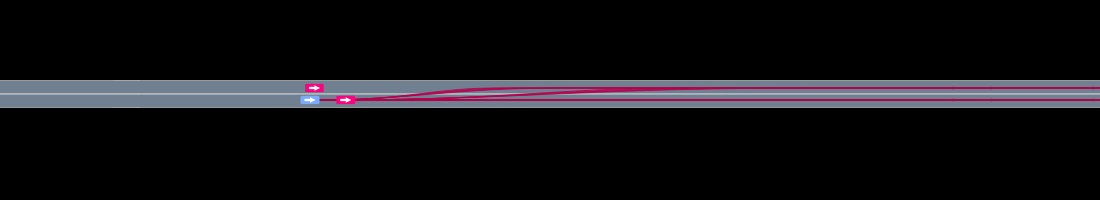

In [130]:
# 1 - generate candidate trajectories
candidate_trajectories = generate_candidate_trajectories(basics, policy, active_carid, validfind)

extracted_trajdefs, extracted_polies = extract_trajdefs(basics, candidate_trajectories, active_carid, validfind)

plot_extracted_trajdefs(pdset, sn, extracted_trajdefs, validfind, active_carid,
                        canvas_width=canvas_width, canvas_height=canvas_height,
                        rendermodel=rendermodel, camerazoom=camerazoom/2,
                        camera_forward_offset=camera_forward_offset)

collision risk: [0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.69,1.0,1.0,1.0,1.0,0.01]


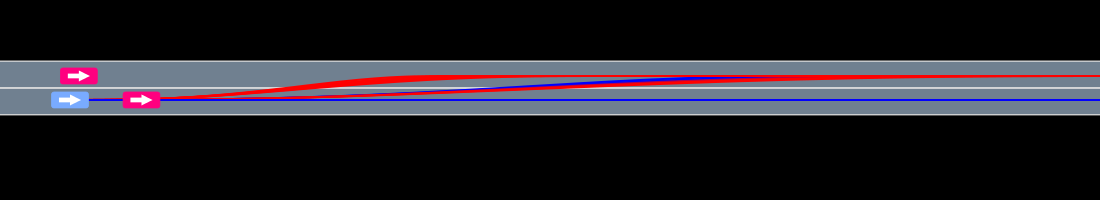

In [131]:
# 2 - simulate candidate trajectories to estimate risk
sec_per_frame = calc_sec_per_frame(basics.pdset)
collision_risk = calc_collision_risk_monte_carlo!(basics, policy, candidate_trajectories, 
                                                      active_carid, validfind, sec_per_frame)

println("collision risk: ", collision_risk)

plot_extracted_trajdefs(pdset, sn, extracted_trajdefs, collision_risk, validfind, active_carid,
                                              canvas_width=canvas_width, canvas_height=canvas_height,
                                              rendermodel=rendermodel, camerazoom=camerazoom,
                                              camera_forward_offset=camera_forward_offset)

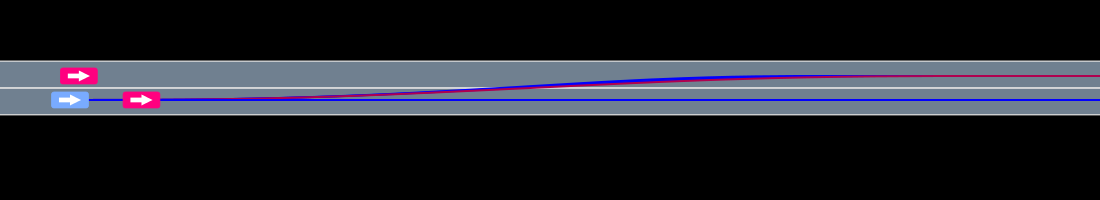

In [132]:
remaining_indeces = find(c->c < 1.0, collision_risk)

plot_extracted_trajdefs(pdset, sn, extracted_trajdefs[remaining_indeces], collision_risk[remaining_indeces], validfind, active_carid,
                                              canvas_width=canvas_width, canvas_height=canvas_height,
                                              rendermodel=rendermodel, camerazoom=camerazoom,
                                              camera_forward_offset=camera_forward_offset)

   i   collision    jerk lat    jerk lon    delta v²   collision    jerk lat    jerk lon    delta v²      total
   1       0.000       0.000       0.684     102.495       0.000       0.000       0.342   10249.508   10249.850
   2       0.000       0.000       0.078     102.495       0.000       0.000       0.039   10249.508   10249.547
   3       0.000       0.000       0.156      26.255       0.000       0.000       0.078    2625.523    2625.600
   4       0.000       0.000       0.016      26.255       0.000       0.000       0.008    2625.523    2625.531
   5       1.000       0.000       0.002       0.015  100000.000       0.000       0.001       1.537  100001.538
   6       1.000       0.000       0.001       0.015  100000.000       0.000       0.001       1.537  100001.538
   7       1.000       0.000       0.223      23.776  100000.000       0.000       0.112    2377.552  102377.664
   8       1.000       0.000       0.033      23.776  100000.000       0.000       0.016    2377.

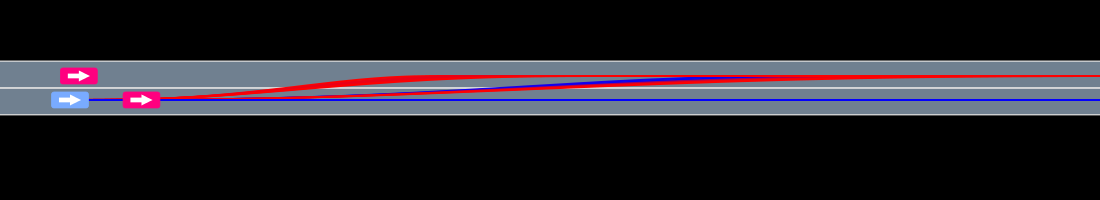

In [133]:
costs = Array(Float64, length(extracted_polies))

# 3 - select the highest-scoring trajectory
best_trajectory_index = 1
best_cost = Inf
for (i,extracted_polynomial_factored_trajectories) in enumerate(extracted_polies)
    cost = calc_cost(extracted_polynomial_factored_trajectories, collision_risk[i], policy)
    costs[i] = cost
    if cost < best_cost
        best_trajectory_index = i
        best_cost = cost
    end
end

@printf("%4s  %10s  %10s  %10s  %10s  %10s  %10s  %10s  %10s %10s\n", "i", "collision", "jerk lat", "jerk lon", "delta v²", "collision", "jerk lat", "jerk lon", "delta v²", "total")
for (k,extracted_polynomial_factored_trajectories) in enumerate(extracted_polies)
    collision_prob = collision_risk[k]
    
    k_c = policy.k_c
    k_s = policy.k_s
    k_v = policy.k_v

    J_s = 0.0
    J_d = 0.0
    for i in 1:length(extracted_polynomial_factored_trajectories)
        poly = extracted_polynomial_factored_trajectories.trajs[i]
        τ = extracted_polynomial_factored_trajectories.durations[i]

        J_s += calc_integrated_squared_jerk(poly.s, τ)
        J_d += calc_integrated_squared_jerk(poly.d, τ)
    end
    J_s *= 0.01
    J_d *= 0.01

    sdot_f = p₂(extracted_polynomial_factored_trajectories.trajs[end].s, extracted_polynomial_factored_trajectories.durations[end])
    ddot_f = p₂(extracted_polynomial_factored_trajectories.trajs[end].d, extracted_polynomial_factored_trajectories.durations[end])
    v_f = sqrt(sdot_f*sdot_f + ddot_f*ddot_f)

    Δv = v_f - policy.desired_speed
    Δv² = Δv*Δv

    cost_Δv = k_v*Δv²
    cost_Jd = (1.0-k_s)*J_d
    cost_Js = k_s*J_s
    cost_c  = k_c*collision_prob
    
    cost = cost_c + cost_Jd + cost_Js + cost_Δv
    
    @printf("%4d  %10.3f  %10.3f  %10.3f  %10.3f  %10.3f  %10.3f  %10.3f  %10.3f  %10.3f\n", k, 
                  collision_prob, J_d, J_s, Δv², cost_c, cost_Jd, cost_Js, cost_Δv, cost)
end
println("best index: ", best_trajectory_index)

max_cost = maximum(costs)

plot_extracted_trajdefs(pdset, sn, extracted_trajdefs, costs./max_cost, validfind, active_carid,
                        canvas_width=canvas_width, canvas_height=canvas_height,
                        rendermodel=rendermodel, camerazoom=camerazoom,
                        camera_forward_offset=camera_forward_offset)

Slider{Int64}([Input{Int64}] 113,"validfind_viz",113,111:115)

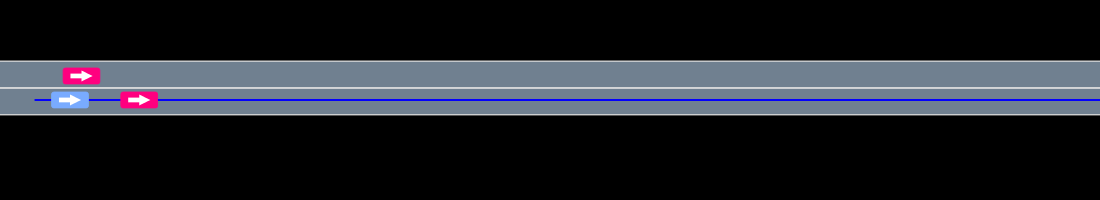

In [134]:
insert!(pdset, extracted_trajdefs[best_trajectory_index], validfind+1, validfind+N_FRAMES_PER_SIM_FRAME)

@manipulate for validfind_viz in validfind+1 : validfind+N_FRAMES_PER_SIM_FRAME
    plot_extracted_trajdefs(pdset, sn, [extracted_trajdefs[best_trajectory_index]], [costs[best_trajectory_index]/max_cost], validfind_viz, active_carid,
                                      canvas_width=canvas_width, canvas_height=canvas_height,
                                      rendermodel=rendermodel, camerazoom=camerazoom,
                                      camera_forward_offset=camera_forward_offset)
end

In [135]:
println(extracted_trajdefs[best_trajectory_index].df[validfind : validfind+N_FRAMES_PER_SIM_FRAME, :velFy])

[-2.4838225345265177e-17,-2.460804788459661e-17,-2.4347700075616384e-17,-2.4057866958549644e-17,-2.373927799961825e-17,-2.3392707091040565e-17]


In [136]:
has_intersection(basics.pdset, validfind, validfind+N_FRAMES_PER_SIM_FRAME)

false

In [137]:
validfind += N_FRAMES_PER_SIM_FRAME

115

# Evaluate

In [26]:
"hidden evaluate_policy"
evaluate_policy(scenario, active_carid, policy, nruns)

LoadError: assertion failed: !(is_extind_at_curve_end(curve,extind))
while loading In[26], in expression starting on line 2

# Run Once

In [25]:
pdset = basics.pdset
validfind_start = scenario.history
validfind_end = scenario.history + 160
for validfind in validfind_start : N_FRAMES_PER_SIM_FRAME : validfind_end-1
    starttime = time()    
    propagate!(basics, policy, active_carid, validfind, N_FRAMES_PER_SIM_FRAME)
end

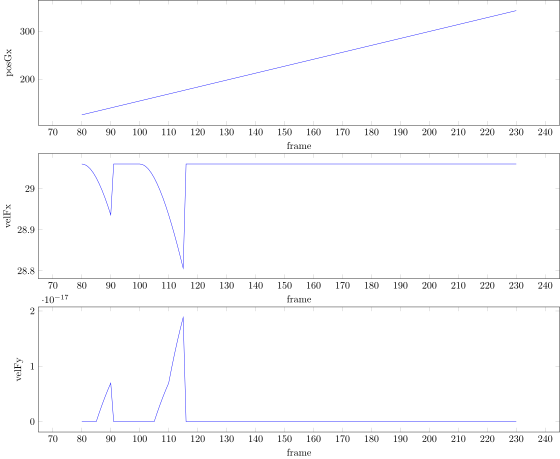

In [138]:
using PGFPlots

pdset = basics.pdset
validfind_arr = [1 : nvalidfinds(pdset)]
posGx_arr = convert(Vector{Float64}, pdset.df_ego[:posGx])
velFx_arr = convert(Vector{Float64}, pdset.df_ego[:velFx])
velFy_arr = convert(Vector{Float64}, pdset.df_ego[:velFy])

range = 80:230
validfind_arr = validfind_arr[range]
posGx_arr = posGx_arr[range]
velFx_arr = velFx_arr[range]
velFy_arr = velFy_arr[range]

group_plot = GroupPlot(1,3)
push!(group_plot, Axis(Plots.Linear(validfind_arr, posGx_arr, mark="none"), xlabel="frame", ylabel="posGx", width="20cm", height="6cm"))
push!(group_plot, Axis(Plots.Linear(validfind_arr, velFx_arr, mark="none"), xlabel="frame", ylabel="velFx", width="20cm", height="6cm"))
push!(group_plot, Axis(Plots.Linear(validfind_arr, velFy_arr, mark="none"), xlabel="frame", ylabel="velFy", width="20cm", height="6cm"))

group_plot

In [29]:
has_intersection(basics.pdset, scenario.history, scenario.history+160)

true

In [ ]:
plots_velFx = PGFPlots.Plot[]
plots_velFy = PGFPlots.Plot[]

validfind_start = scenario.history
validfind_end = scenario.history + 160

validfinds = [validfind_start : validfind_end]

for validfind in validfind_start : N_FRAMES_PER_SIM_FRAME : validfind_end-1
    starttime = time()
    
    candidate_trajectories = generate_candidate_trajectories(basics, policy, active_carid, validfind)
    extracted_trajdefs, extracted_polies = extract_trajdefs(basics, candidate_trajectories, active_carid, validfind)

    sec_per_frame = calc_sec_per_frame(basics.pdset)
    collision_risk = calc_collision_risk_monte_carlo!(basics, policy, candidate_trajectories, 
                                                      active_carid, validfind, sec_per_frame)
    best_trajectory_index = indmin(collision_risk)

    insert!(basics.pdset, extracted_trajdefs[best_trajectory_index])
    
    velFx_arr = convert(Vector{Float64}, pdset.df_ego[validfinds, :velFx])
    velFy_arr = convert(Vector{Float64}, pdset.df_ego[validfinds, :velFy])
    push!(plots_velFx, Plots.Linear(validfinds, velFx_arr, mark="none"))
    push!(plots_velFy, Plots.Linear(validfinds, velFy_arr, mark="none"))
end

In [ ]:
Axis(plots_velFx, xlabel="frame", ylabel="velFx", width="20cm", height="20cm")

In [ ]:
Axis(plots_velFy, xlabel="frame", ylabel="velFy", width="20cm", height="20cm")

Slider{Int64}([Input{Int64}] 160,"validfind",160,80:240)

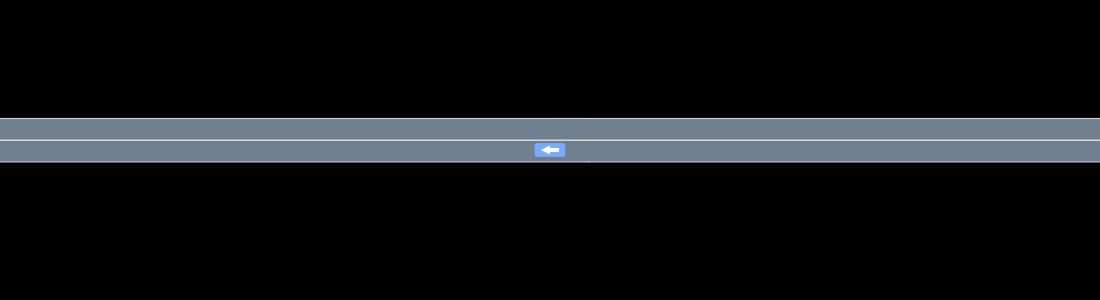

In [32]:
plot_manipulable_pdset(pdset, sn, active_carid, validfind_start=validfind_start, validfind_end=validfind_end)